In [2]:
%matplotlib inline

from modsim import *

In [3]:
r_coffee = 0.00019348499840078214 #I calculated this using the code from notebook 7, this is a factor that allows us 
                                  # to use 1 second increments instead of 1 minute increments 
                                  # times should be multiplied by 60 to get actual time in seconds
init = State(temp=90, steeping = 0)
tea = System(init=init, volume=300, 
             r = 0.012, s_inf=1.01,
                T_env=22,
                t0=0, 
                t_end=30,
                dt=1)

In [4]:
def update(state, system):
    """Update the thermal transfer and steeping factor
    
    state: State (temp, steeping)
    system: System object
    
    returns: State (temp, steeping)
    """
    unpack(system)
    T = state.temp
    T += -r * (T - T_env) * dt
    
    sf = state.steeping
    dsfdt = exp(-1/T)*(sf - s_inf)**2
    sf += dsfdt*dt

    return State(temp=T, steeping = sf)

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], system)
    
    system.results = frame

In [6]:
run_simulation(tea, update)


In [7]:
def make_system(T_init=90, r=0.01, s_inf = 1.01, volume=300, t_end=30):
    """Makes a system with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(temp=T_init, steeping = 0)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    s_inf = s_inf,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

In [23]:
def final_steeping(system):
    """Final steeping factor.
    
    If system has no results, return initial steeping factor.
    
    system: System object.
    
    returns: steeping factor (arbitrary units)
    """    
    if hasattr(system, 'results'):
        return system.results.steeping[system.t_end]
    else:
        return system.init.temp
    
def error_func(s_inf):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r = r_coffee, s_inf = s_inf, volume=300, t_end=60*1) #Change t_end to determine how long the
                                                            #tea takes to get to a certain percent of s_inf
    run_simulation(system, update)
    return final_steeping(system) - s_inf * 0.5            #this number is the percent of s_sinf the system reaches by 8 minutes

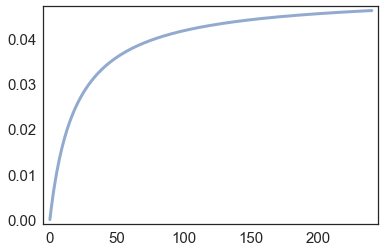

In [24]:

system = make_system(T_init=90, r = r_coffee, s_inf = .05, volume=300, t_end=240)
run_simulation(system, update)
plot(system.results.steeping)

In [25]:
solution = fsolve(error_func, 1) #usinf fsolve to find the steeping factor at infinity assuming full brewing at 8 minutes
s_inf = solution[0]
s_inf


0.016660092207575108

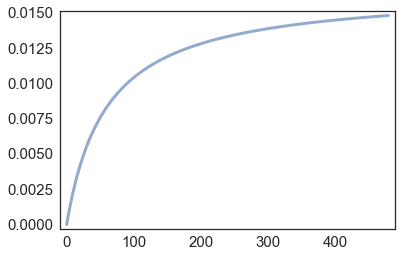

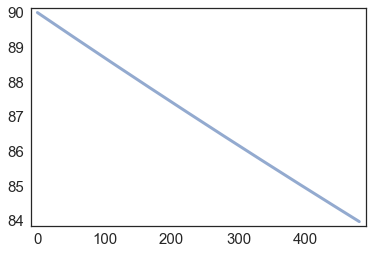

In [26]:
system = make_system(T_init=90, r = r_coffee, s_inf = s_inf, volume=300, t_end=60*8)
run_simulation(system, update)
plot(system.results.steeping)
newfig()
plot(system.results.temp)

In [163]:
error_func(1)

0.0022620086844880039

In [204]:
tea = make_system(T_init=90, r = r_coffee, s_inf = 1.01, volume=300, t_end=240)
update(tea.init, tea)

,value
temp,89.973689
steeping,1.008825


In [186]:
exp(-1/90)*(0 - 0.05)**2

0.0024723759732348063